# Part 2

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

# Helper functions
def is_integer(x):
   
    try:
        return (int(x) == float(x))
    except:
        return False

def ingest_files(directory: str):
    
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print(" Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print(" Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

def visualize_columns(float_cols , perc_cols, cat_cols, date_cols ):
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = min(final_data[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id",
                "loan_amnt",
                "funded_amnt",
                "revol_util",
                "revol_bal",
                "fico_range_low",
                "fico_range_high",
                "pub_rec",
                "open_acc",
                "earliest_cr_line",
                "delinq_2yrs",
                "dti",
                "purpose",
                "issue_d",
                "annual_inc",
                "home_ownership",
                "emp_length",
                "grade",
                "term",
                "int_rate",
                "installment",
                "verification_status",
                "recoveries",
                "loan_status",
                "last_pymnt_d",
                "total_pymnt",
               "loan_length"]

# Identify the type of each of these column

float_cols = ["loan_amnt",
                "funded_amnt",
                "revol_bal",
                "fico_range_low",
                "fico_range_high",
                "pub_rec",
                "open_acc",
                "delinq_2yrs",
                "dti",
                "annual_inc",
                "installment",
                "recoveries",
                "total_pymnt",
              "loan_length"]

cat_cols = ["purpose",
            "home_ownership",
            "emp_length",
            "grade",
            "term",
            "verification_status",
            "loan_status"]

perc_cols = ["revol_util",
             "int_rate"]

date_cols = ["earliest_cr_line",
             "issue_d",
             "last_pymnt_d"]


# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

# Define the names of the four returns we'll be calculating
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb", "ret_INTc"]

# Some of the columns selected will not be used directly in the model, but will be used to generate other features.
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

# Question 1

In [2]:
# Read in data
print ("Reading in data...")

filepath = os.path.join(os.getcwd(), 'Data', 'cleanedData.csv')

data_all = pd.read_csv(filepath)
# Keep only the columns we care about
final_data = data_all[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Reading in data...
Starting with 777266 rows


In [3]:
final_data

,id,loan_amnt,funded_amnt,revol_util,revol_bal,fico_range_low,fico_range_high,pub_rec,open_acc,earliest_cr_line,...,grade,term,int_rate,installment,verification_status,recoveries,loan_status,last_pymnt_d,total_pymnt,loan_length
0,74121690,6000.0,6000.0,63.0,15055.0,675.0,679.0,0.0,16.0,2006-05-01,...,C,36 months,12.99,202.14,Not Verified,0.00,Fully Paid,2019-04-01,7268.153165,36.994599
1,74826201,7200.0,7200.0,18.4,9309.0,750.0,754.0,0.0,11.0,2001-12-01,...,A,36 months,5.32,216.83,Source Verified,0.00,Fully Paid,2016-04-01,7223.410000,1.018501
2,75061311,12000.0,12000.0,50.6,12152.0,670.0,674.0,0.0,10.0,1999-12-01,...,C,60 months,11.99,266.88,Not Verified,443.49,Charged Off,2018-11-01,8448.900000,32.033512
3,75091735,11425.0,11425.0,7.2,2096.0,730.0,734.0,0.0,11.0,2008-09-01,...,D,36 months,19.53,421.87,Source Verified,0.00,Fully Paid,2017-11-01,14331.034913,20.041479
4,75235366,20625.0,20625.0,63.6,10742.0,695.0,699.0,0.0,10.0,1990-05-01,...,B,36 months,10.75,672.80,Source Verified,0.00,Fully Paid,2018-09-01,24142.676489,30.029364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777261,153108303,12000.0,12000.0,9.7,15839.0,735.0,739.0,0.0,17.0,2004-12-01,...,A,36 months,7.02,370.64,Not Verified,0.00,Fully Paid,2019-08-01,12042.850168,1.018501
777262,154311563,6000.0,6000.0,83.4,18852.0,705.0,709.0,0.0,8.0,2001-12-01,...,D,36 months,20.00,222.99,Not Verified,0.00,Fully Paid,2019-10-01,6333.814970,3.022649
777263,153817414,12000.0,12000.0,15.7,1317.0,710.0,714.0,0.0,8.0,2006-12-01,...,C,60 months,15.24,287.00,Not Verified,0.00,Fully Paid,2019-10-01,12520.400076,3.022649
777264,154053832,15000.0,15000.0,4.1,697.0,775.0,779.0,0.0,9.0,2006-12-01,...,A,36 months,8.81,475.68,Not Verified,0.00,Fully Paid,2019-09-01,15287.033886,2.037003


# Question 2

In [4]:
# Read in data
print ("Reading in data...")

# Tell where the directories that contain the files downloaded in 2017 and 2019
dir_2017 = "/".join(["Data"] + ["1712_download"] )
dir_2019 = "/".join(["Data"] + ["1912_download"] )

# Ingest the set of files downloaded in 2017 and then the files downloaded in 2019
files_2017 = ingest_files(dir_2017)
files_2019 = ingest_files(dir_2019)

Reading in data...
Directory Data/1712_download/ has 8 files:
 Reading file LoanStats_securev1_2016Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q4.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q3.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2017Q4.csv
 Found 2 invalid rows which were removed
Directory Data/1912_download/ has 8 files:
 Reading file LoanStats_securev1_2016Q1.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q2.csv
 Found 2 invalid rows which were removed
 Reading file LoanStats_securev1_2016Q3.csv
 

In [5]:
# Check the two sets of files have the same number of files
# with the same names
assert len(files_2017) == len(files_2019)
assert sorted(files_2017) == sorted(files_2019)

# Ensure each set of files has the same loan IDs in both instances
for i in files_2017:
    assert sorted(files_2017[i].id) == sorted(files_2019[i].id)
    

data_2017 = pd.concat(files_2017.values()).reset_index(drop = True)
data_2019 = pd.concat(files_2019.values()).reset_index(drop = True)

print("Loading complete, let's compare columns...")
print(set(data_2017.columns) - set(data_2019.columns))

print("Looks like disbursement_method is not found on 2019 data, we will remove this column.")

# There is somethings that not quite right
# 2017 dataset has an additional column which is disbursement_method
data_2017.drop(['disbursement_method'], axis=1, inplace=True)

print("Now we will merge the two datasets to compare...")

# Ensure the loan IDs are a unique key
assert len(set(data_2019.id)) == len(data_2019)
assert len(set(data_2017.id)) == len(data_2017)

# Ensure columns are same
columns = list(data_2017.columns)
assert sorted(columns) == sorted(data_2019.columns)

# Just in case, check the datasets have the same number of rows
n_rows = len(data_2017)
assert n_rows == len(data_2019)

# Merge them
Compare_2017_2019 = pd.merge(data_2017, data_2019, how = 'inner', on="id", suffixes=('_x', '_y'))

# Ensure the merged dataset has the same number of rows
assert n_rows == len(Compare_2017_2019)

print("Let's look for static columns...")

# Go through each column, and find what percentage of the values in
# that column are identical in the two datasets
static_perc = {}

# Remove the ID column first
columns = [i for i in columns if i != "id"]

for i in columns:
    Compare_2017_2019[i+"_comp"] = (Compare_2017_2019[i+"_x"] == Compare_2017_2019[i+"_y"]) | (Compare_2017_2019[i+"_x"].isnull() & Compare_2017_2019[i+"_y"].isnull())
    static_perc[i] = Compare_2017_2019[i+"_comp"].sum()*100.0/len(Compare_2017_2019)
    
static_perc = pd.DataFrame([ [i, static_perc[i]] for i in static_perc], columns=["column", "perc_equal"]).\
                                                    sort_values("perc_equal", ascending = False)

# Ensure that the columns we want to pick for our model are in
# the above, and check how consistent they've been
assert set(cols_to_pick) - set(static_perc.column) - set(["id"]) == set()

print("Below is the percentange of data for each of our columns that is the same:")

print(static_perc[static_perc.column.isin(cols_to_pick)])


Loading complete, let's compare columns...
{'disbursement_method'}
Looks like disbursement_method is not found on 2019 data, we will remove this column.
Now we will merge the two datasets to compare...
Let's look for static columns...


AssertionError: 

In [7]:
# There are 35 rows where the int_rate_comp and installment_comp values do not have same comparison
(Compare_2017_2019["int_rate_comp"] != Compare_2017_2019["installment_comp"]).sum()

# what do you notice looking at these loans?
Compare_2017_2019.loc[(Compare_2017_2019["int_rate_comp"] != Compare_2017_2019["installment_comp"]),:].loc[:,['id','int_rate_x','int_rate_y','term_x','term_y','installment_x','installment_y']]

,id,int_rate_x,int_rate_y,term_x,term_y,installment_x,installment_y
39618,74722704,10.75%,10.75%,60 months,60 months,432.36,405.03
88840,71003261,6.00%,11.16%,36 months,36 months,452.35,452.35
99418,70391991,6.00%,6.00%,36 months,36 months,655.91,653.38
102292,69980465,6.00%,6.00%,60 months,60 months,704.42,699.75
184837,78600054,13.67%,13.67%,60 months,60 months,461.96,441.9
198862,77538744,6.00%,6.00%,36 months,36 months,1032.57,1032.72
231097,76012596,6.00%,6.00%,60 months,60 months,467.41,461.68
295368,86136443,14.49%,14.49%,60 months,60 months,258.76,134.1
320463,83709004,19.99%,19.99%,60 months,60 months,303.04,279.86
384458,93413738,12.74%,12.74%,36 months,36 months,211.49,195.32


In [8]:
# So the differences in int_rate and installment are the same. Let's look at them
Compare_2017_2019[Compare_2017_2019.int_rate_comp == False][["id", "issue_d_x", "issue_d_y", "term_x", "term_y", "int_rate_x", "int_rate_y"]]

,id,issue_d_x,issue_d_y,term_x,term_y,int_rate_x,int_rate_y
11702,75132541,Mar-2016,Mar-2016,60 months,60 months,7.89%,6.00%
12709,74131643,Mar-2016,Mar-2016,36 months,36 months,6.97%,6.00%
18972,75101560,Mar-2016,Mar-2016,60 months,60 months,19.53%,6.00%
20946,75314580,Mar-2016,Mar-2016,60 months,60 months,10.75%,6.00%
26817,74522695,Mar-2016,Mar-2016,60 months,60 months,18.99%,6.00%
...,...,...,...,...,...,...,...
862147,118169441,Oct-2017,Oct-2017,60 months,60 months,18.06%,6.00%
862390,120953984,Oct-2017,Oct-2017,36 months,36 months,14.08%,6.00%
867463,120631915,Oct-2017,Oct-2017,60 months,60 months,9.93%,6.00%
871222,120554473,Oct-2017,Oct-2017,36 months,36 months,12.62%,6.00%


# Question 3

In [9]:
# Read in data
print ("Reading in data...")


filepath = os.path.join(os.getcwd(), 'Data', 'cleanedData.csv')

data_all = pd.read_csv(filepath, parse_dates=["earliest_cr_line","issue_d","last_pymnt_d"])
# Keep only the columns we care about
final_data = data_all[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Reading in data...
Starting with 777266 rows


In [10]:
final_data 

,id,loan_amnt,funded_amnt,revol_util,revol_bal,fico_range_low,fico_range_high,pub_rec,open_acc,earliest_cr_line,...,grade,term,int_rate,installment,verification_status,recoveries,loan_status,last_pymnt_d,total_pymnt,loan_length
0,74121690,6000.0,6000.0,63.0,15055.0,675.0,679.0,0.0,16.0,2006-05-01,...,C,36 months,12.99,202.14,Not Verified,0.00,Fully Paid,2019-04-01,7268.153165,36.994599
1,74826201,7200.0,7200.0,18.4,9309.0,750.0,754.0,0.0,11.0,2001-12-01,...,A,36 months,5.32,216.83,Source Verified,0.00,Fully Paid,2016-04-01,7223.410000,1.018501
2,75061311,12000.0,12000.0,50.6,12152.0,670.0,674.0,0.0,10.0,1999-12-01,...,C,60 months,11.99,266.88,Not Verified,443.49,Charged Off,2018-11-01,8448.900000,32.033512
3,75091735,11425.0,11425.0,7.2,2096.0,730.0,734.0,0.0,11.0,2008-09-01,...,D,36 months,19.53,421.87,Source Verified,0.00,Fully Paid,2017-11-01,14331.034913,20.041479
4,75235366,20625.0,20625.0,63.6,10742.0,695.0,699.0,0.0,10.0,1990-05-01,...,B,36 months,10.75,672.80,Source Verified,0.00,Fully Paid,2018-09-01,24142.676489,30.029364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777261,153108303,12000.0,12000.0,9.7,15839.0,735.0,739.0,0.0,17.0,2004-12-01,...,A,36 months,7.02,370.64,Not Verified,0.00,Fully Paid,2019-08-01,12042.850168,1.018501
777262,154311563,6000.0,6000.0,83.4,18852.0,705.0,709.0,0.0,8.0,2001-12-01,...,D,36 months,20.00,222.99,Not Verified,0.00,Fully Paid,2019-10-01,6333.814970,3.022649
777263,153817414,12000.0,12000.0,15.7,1317.0,710.0,714.0,0.0,8.0,2006-12-01,...,C,60 months,15.24,287.00,Not Verified,0.00,Fully Paid,2019-10-01,12520.400076,3.022649
777264,154053832,15000.0,15000.0,4.1,697.0,775.0,779.0,0.0,9.0,2006-12-01,...,A,36 months,8.81,475.68,Not Verified,0.00,Fully Paid,2019-09-01,15287.033886,2.037003


In [11]:

print("Saving pickle file...")
# Define the output path for the pickle
pickle_file = "/".join(["Data"] + ["clean_data.pickle"] )

pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )
print("Saved to Data/clean_data.pickle")

Saving pickle file...
Saved to Data/clean_data.pickle


# Question 4

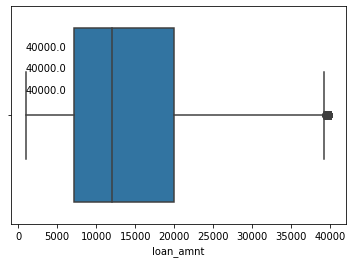

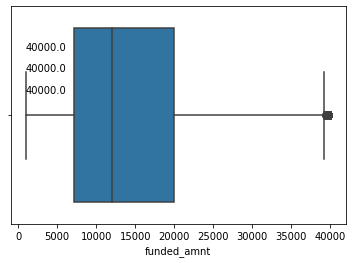

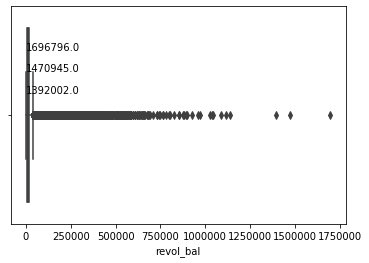

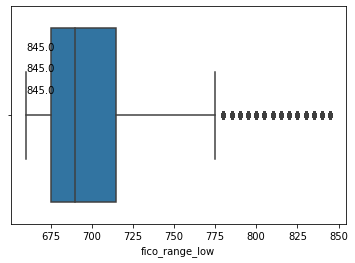

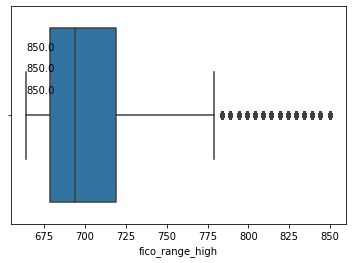

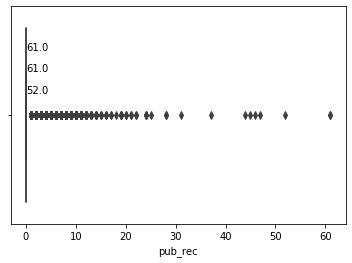

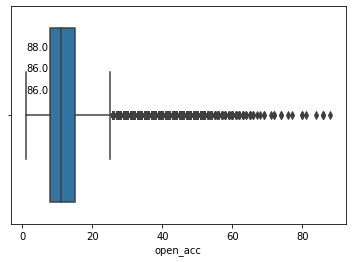

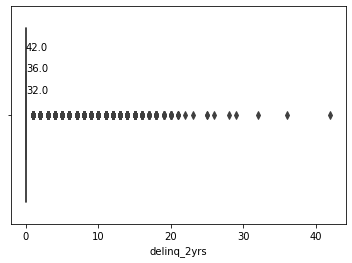

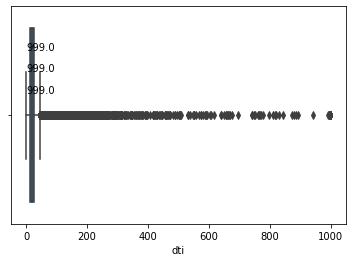

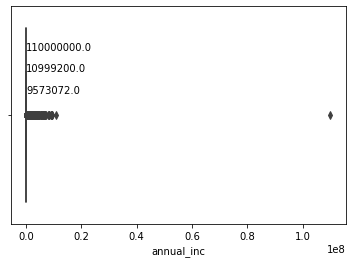

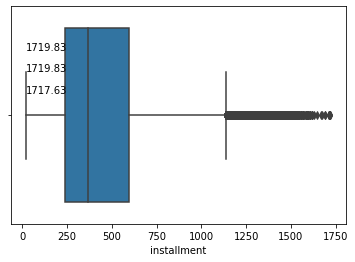

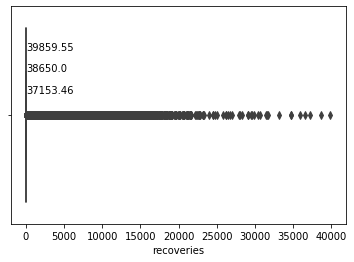

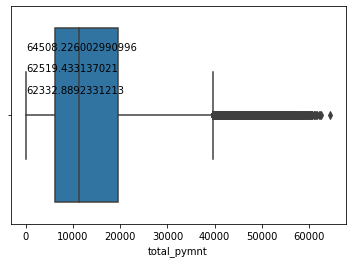

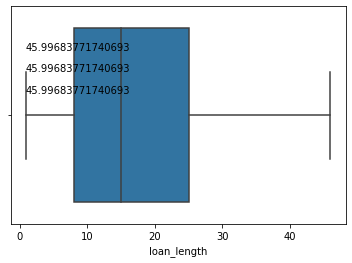

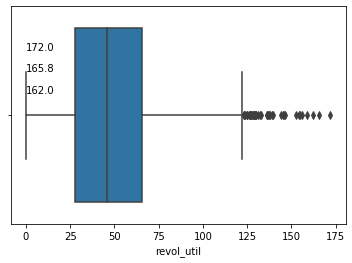

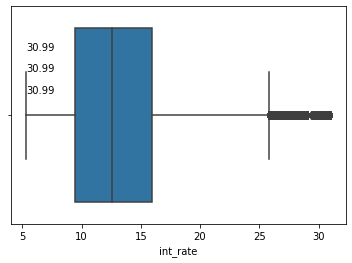

purpose
14 distinct values
debt_consolidation    435689
credit_card           162117
home_improvement       57861
other                  55484
major_purchase         19279
medical                10885
car                     8861
small_business          8191
vacation                6657
moving                  6173
house                   5514
renewable_energy         548
wedding                    6
educational                1
Name: purpose, dtype: int64


home_ownership
5 distinct values
MORTGAGE    381861
RENT        300608
OWN          94124
ANY            669
NONE             4
Name: home_ownership, dtype: int64


emp_length
12 distinct values
10+ years    258833
2 years       71538
< 1 year      64309
3 years       63097
1 year        52360
5 years       47771
4 years       47411
6 years       33737
8 years       28888
9 years       27100
7 years       26712
Name: emp_length, dtype: int64


grade
7 distinct values
B    232034
C    229644
A    146737
D    108821
E     41686
F    

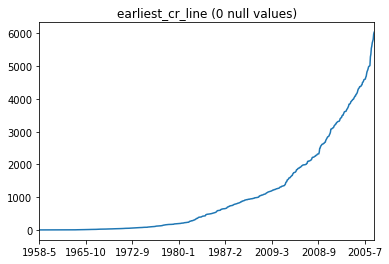

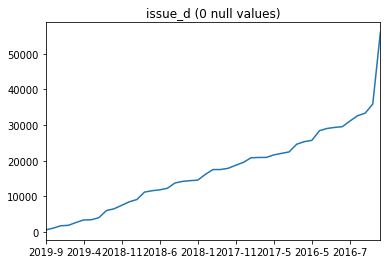

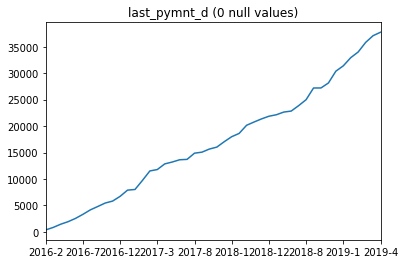

In [12]:
# Visualize the data
visualize_columns(float_cols , perc_cols, cat_cols, date_cols )

Removed 7 rows


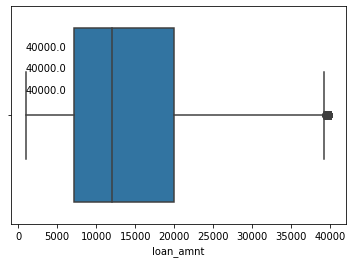

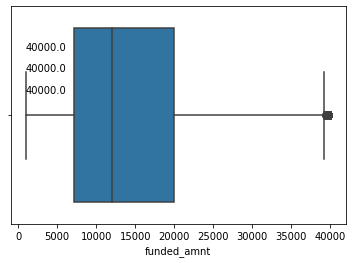

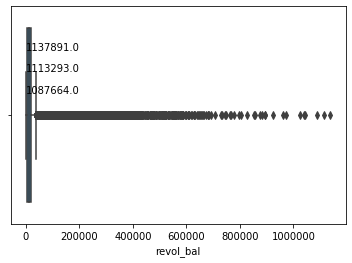

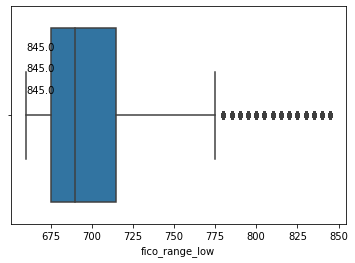

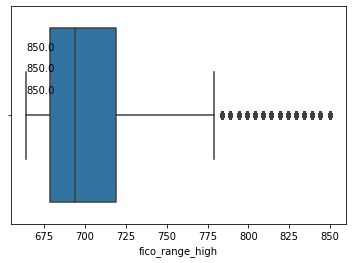

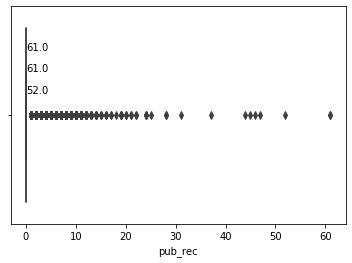

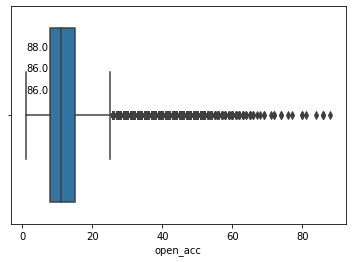

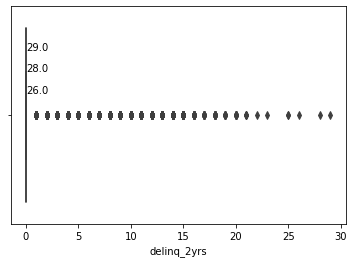

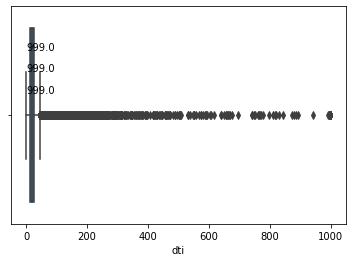

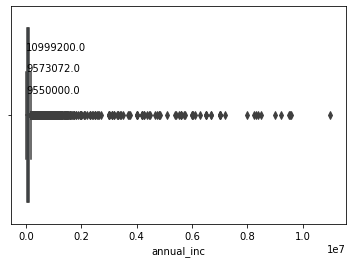

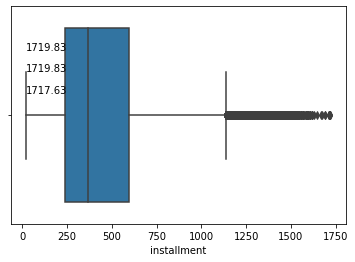

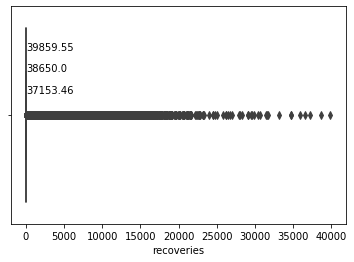

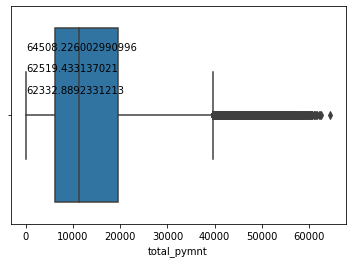

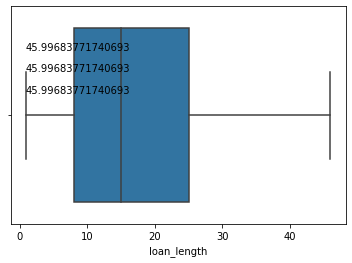

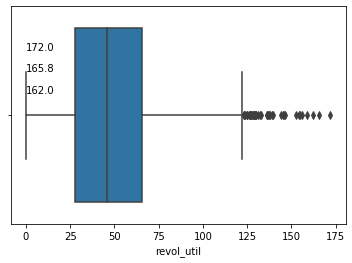

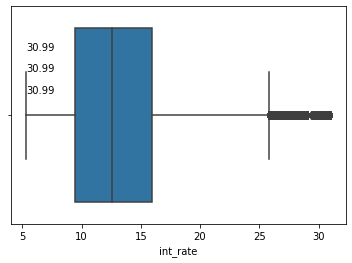

purpose
14 distinct values
debt_consolidation    435688
credit_card           162114
home_improvement       57859
other                  55484
major_purchase         19279
medical                10885
car                     8861
small_business          8190
vacation                6657
moving                  6173
house                   5514
renewable_energy         548
wedding                    6
educational                1
Name: purpose, dtype: int64


home_ownership
5 distinct values
MORTGAGE    381856
RENT        300606
OWN          94124
ANY            669
NONE             4
Name: home_ownership, dtype: int64


emp_length
12 distinct values
10+ years    258829
2 years       71538
< 1 year      64309
3 years       63096
1 year        52360
5 years       47771
4 years       47411
6 years       33737
8 years       28888
9 years       27100
7 years       26712
Name: emp_length, dtype: int64


grade
7 distinct values
B    232032
C    229643
A    146736
D    108820
E     41684
F    

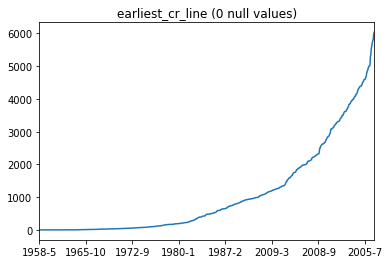

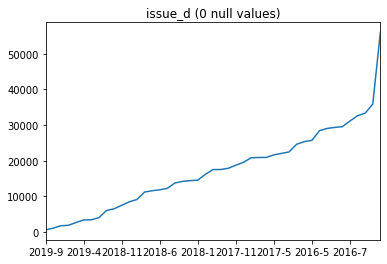

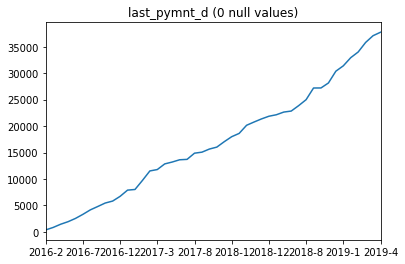

In [13]:
# Remove outliers and then vizualize the data again
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 100000000]
final_data = final_data[final_data.revol_bal < 1250000]
final_data = final_data[final_data.delinq_2yrs < 32]
print("Removed " + str(n_rows - len(final_data)) + " rows")

# Visualize the data
visualize_columns(float_cols , perc_cols, cat_cols, date_cols)

# Part 3 – Data Exploration 

# Question 1


# Question 2

In [84]:
# Return Method 2 (pessimistic)

In [14]:
# Calculate the return using a simple annualized profit margin
# Pessimistic fefinition (method 2)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int)
final_data['ret_PESS'] = ( (final_data.total_pymnt - final_data.funded_amnt) 
                                            / final_data.funded_amnt ) * (12 / final_data['term_num'])

In [15]:
final_data

,id,loan_amnt,funded_amnt,revol_util,revol_bal,fico_range_low,fico_range_high,pub_rec,open_acc,earliest_cr_line,...,int_rate,installment,verification_status,recoveries,loan_status,last_pymnt_d,total_pymnt,loan_length,term_num,ret_PESS
0,74121690,6000.0,6000.0,63.0,15055.0,675.0,679.0,0.0,16.0,2006-05-01,...,12.99,202.14,Not Verified,0.00,Fully Paid,2019-04-01,7268.153165,36.994599,36,0.070453
1,74826201,7200.0,7200.0,18.4,9309.0,750.0,754.0,0.0,11.0,2001-12-01,...,5.32,216.83,Source Verified,0.00,Fully Paid,2016-04-01,7223.410000,1.018501,36,0.001084
2,75061311,12000.0,12000.0,50.6,12152.0,670.0,674.0,0.0,10.0,1999-12-01,...,11.99,266.88,Not Verified,443.49,Charged Off,2018-11-01,8448.900000,32.033512,60,-0.059185
3,75091735,11425.0,11425.0,7.2,2096.0,730.0,734.0,0.0,11.0,2008-09-01,...,19.53,421.87,Source Verified,0.00,Fully Paid,2017-11-01,14331.034913,20.041479,36,0.084786
4,75235366,20625.0,20625.0,63.6,10742.0,695.0,699.0,0.0,10.0,1990-05-01,...,10.75,672.80,Source Verified,0.00,Fully Paid,2018-09-01,24142.676489,30.029364,36,0.056851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777261,153108303,12000.0,12000.0,9.7,15839.0,735.0,739.0,0.0,17.0,2004-12-01,...,7.02,370.64,Not Verified,0.00,Fully Paid,2019-08-01,12042.850168,1.018501,36,0.001190
777262,154311563,6000.0,6000.0,83.4,18852.0,705.0,709.0,0.0,8.0,2001-12-01,...,20.00,222.99,Not Verified,0.00,Fully Paid,2019-10-01,6333.814970,3.022649,36,0.018545
777263,153817414,12000.0,12000.0,15.7,1317.0,710.0,714.0,0.0,8.0,2006-12-01,...,15.24,287.00,Not Verified,0.00,Fully Paid,2019-10-01,12520.400076,3.022649,60,0.008673
777264,154053832,15000.0,15000.0,4.1,697.0,775.0,779.0,0.0,9.0,2006-12-01,...,8.81,475.68,Not Verified,0.00,Fully Paid,2019-09-01,15287.033886,2.037003,36,0.006379


In [91]:
#Return Method 1 (optimistic)

In [16]:

# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 2 to compute the return

final_data['ret_OPT'] = ( (final_data.total_pymnt - final_data.funded_amnt)
                                            / final_data.funded_amnt ) * (12 / final_data['loan_length'])
final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.ret_PESS[final_data.ret_OPT < 0]


In [17]:
final_data

,id,loan_amnt,funded_amnt,revol_util,revol_bal,fico_range_low,fico_range_high,pub_rec,open_acc,earliest_cr_line,...,installment,verification_status,recoveries,loan_status,last_pymnt_d,total_pymnt,loan_length,term_num,ret_PESS,ret_OPT
0,74121690,6000.0,6000.0,63.0,15055.0,675.0,679.0,0.0,16.0,2006-05-01,...,202.14,Not Verified,0.00,Fully Paid,2019-04-01,7268.153165,36.994599,36,0.070453,0.068559
1,74826201,7200.0,7200.0,18.4,9309.0,750.0,754.0,0.0,11.0,2001-12-01,...,216.83,Source Verified,0.00,Fully Paid,2016-04-01,7223.410000,1.018501,36,0.001084,0.038308
2,75061311,12000.0,12000.0,50.6,12152.0,670.0,674.0,0.0,10.0,1999-12-01,...,266.88,Not Verified,443.49,Charged Off,2018-11-01,8448.900000,32.033512,60,-0.059185,-0.059185
3,75091735,11425.0,11425.0,7.2,2096.0,730.0,734.0,0.0,11.0,2008-09-01,...,421.87,Source Verified,0.00,Fully Paid,2017-11-01,14331.034913,20.041479,36,0.084786,0.152299
4,75235366,20625.0,20625.0,63.6,10742.0,695.0,699.0,0.0,10.0,1990-05-01,...,672.80,Source Verified,0.00,Fully Paid,2018-09-01,24142.676489,30.029364,36,0.056851,0.068155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777261,153108303,12000.0,12000.0,9.7,15839.0,735.0,739.0,0.0,17.0,2004-12-01,...,370.64,Not Verified,0.00,Fully Paid,2019-08-01,12042.850168,1.018501,36,0.001190,0.042072
777262,154311563,6000.0,6000.0,83.4,18852.0,705.0,709.0,0.0,8.0,2001-12-01,...,222.99,Not Verified,0.00,Fully Paid,2019-10-01,6333.814970,3.022649,36,0.018545,0.220876
777263,153817414,12000.0,12000.0,15.7,1317.0,710.0,714.0,0.0,8.0,2006-12-01,...,287.00,Not Verified,0.00,Fully Paid,2019-10-01,12520.400076,3.022649,60,0.008673,0.172167
777264,154053832,15000.0,15000.0,4.1,697.0,775.0,779.0,0.0,9.0,2006-12-01,...,475.68,Not Verified,0.00,Fully Paid,2019-09-01,15287.033886,2.037003,36,0.006379,0.112728


In [93]:
# Method 3 (re-investment) we choose  the nominal length of the loan in months T =60, i=1.2% and i=3%

In [20]:
def ret_method_3(T=60, i=0.012):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )


In [21]:
def ret_method_3(T=60, i=0.03):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )


In [22]:
## you will need to provide the appropriate parameters to the function call
final_data['ret_INTa'] = ret_method_3(60, 0.012)
final_data['ret_INTb'] = ret_method_3(60, 0.03)
#final_data['ret_INTc'] = ret_method_3(?, ?)

# Question 3

In [24]:
# the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 )
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)*100 )
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)*100 )
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)*100 )
#ret_by_grade_INTc = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTc)*100 )
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))

combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb
#combined['return_INTc'] = ret_by_grade_INTc

combined

,grade,default,int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,18.878649,6.688202,6.981111,3.849987,1.036231,17.676057,73.328106
B,29.852597,14.919925,10.477374,4.647987,0.764227,17.155566,71.460031
C,29.545235,24.604277,14.113938,5.069459,-0.179101,16.090063,69.388477
D,14.000481,33.378974,18.758691,5.754895,-1.230440,14.921877,67.510753
E,5.362949,41.584301,23.610656,6.633313,-1.741585,14.073758,65.397030
F,1.727352,50.357515,27.434500,6.456103,-2.456857,12.536237,61.588520
G,0.632736,54.005693,29.965842,6.227061,-3.346234,11.530837,59.878893


In [25]:
# a. How many loans are in each grade? 


# b. What is the default rate in each grade?  



# c. What is the average interest rate in each grade?  



# d. What is the average percentage (annual) return for each grade using each of the return calculations? 




In [26]:
#Calculate and describe the skewness and kurtosis 
# e.

from scipy.stats import kurtosis, skew

print('kurtosis is: {}'.format(kurtosis(final_data.int_rate)))


# f.
print('skewness is: {}'.format(skew(final_data.int_rate)))




kurtosis is: 0.7923544477040756
skewness is: 0.9274099762056969
